# Venues effect on Barcelona's 2nd-hand house market

## 1. Introduction

This article follows an analysis of Barcelona’s second-hand properties economy. Numerous are analyses of Barcelona's real estate market, a market more and more influenced by foreign investors and where landlords have realized they can make more money out of short lets to well-off Airbnb users than from renting to conventional tenants who live and work in the city year round.

Urban residential house prices depend on two broad factors:
1. tangible factors: characteristics of the house
2. intangible factors: neighborhood characteristics, services, and environment. 
This second relationship, between housing preferences and the characteristics of the neighborhood, is complex and it is hard to assess the contribution of the different neighborhood aspects to the property price, because of different attributes of the residential environment show high correlations with each other. It's necessary to consider also that different housing sub-markets exist, in which dwellings in one sub-market are not realistic substitutes for dwellings in the other.

Since the 70's numerous neighborhood externalities have been evaluated for their impact on residential property values, including rail transit stations, greenbelts and open spaces,churches and landfills. A couple of prime examples of commercial property that impacts property values of a neighborhood positively would be lively nightlife venues, art galleries, or coffee shops. Reports have shown that a smaller, neighborhood movie theater, just as an example, can increase a home’s property value by as much as  <a href="http://homeguides.sfgate.com/effects-commercial-property-residential-value-7923.html">14 to 30 percent</a>. Smaller movie theaters are very much welcomed in residential areas, especially if they are in an inner-city, trending neighborhood. Much the same impact can be seen with grocery stores, and homes <a href="https://www.zillow.com/research/starbucks-home-value-appreciation-8912/">near Starbucks locations appreciate</a> faster than the typical U.S. home.

This analysis, that can be used by Barcelona house buyers and sellers, real estate agents and investors, serves to discover the effects of different venues(obtained using the Foursquare API) on the 2nd-hand housing market.These effects are accounted for at the neighborhood level.

## 2. Data and Packages

Data used in the analysis:
1. In the statistical part of Barcelona's website is possible to find the 2018 average price for 2nd hand houses: http://www.bcn.cat/estadistica/catala/dades/timm/ipreus/hab2mave/evo/t2mab.htm. The web page, embedded in the HTML code, contains divided by neighborhoods the average price by neighborhoods(barrios), in euros per square meter, of second hand properties. 
2. On <a href="https://github.com/martgnz/bcn-geodata/commits?author=martgnz">martgnz GitHub</a>is available the Barcelona Geodata, the official shapefiles from Barcelona, converted to GeoJSON. I will use the GeoJSON containing the split by neighborhood and the <a href='https://pypi.org/project/Shapely/'>shapely library</a> to individuate the centroid of each neighborhood polygon
3. From Foursquare (through the API) I obtained the full details about the venues including location and categories.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import random
import re
from scipy import stats

# Web-scraping libraries
import requests
import lxml.html as lh
from bs4 import BeautifulSoup

# Plot libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

# Geo-rendering library
import folium

# Iphyton libraries
from IPython.display import Image
from IPython.core.display import HTML 

# import kmean for later clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
!conda install -c conda-forge shapely --y

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    basemap-1.2.0              |   py36h673bf1a_2        15.2 MB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2019.3.9           |           py36_0         149 KB  conda-forge
    conda-4.6.8                |           py36_0         876 KB  conda-forge
    geos-3.7.1                 |    hf484d3e_1000         1.6 MB  conda-forge
    openssl-1.1.1b             |       h14c3975_1         4.0 MB  conda-forge
    shapely-1.6.4              |py36h092830f_1002         330 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        22.2 MB

The following NEW packages will be INSTALLE

In [3]:
# planar features library
from shapely.geometry import Polygon

### Price Data
In the Barcelona's website is possible to find the 2018 average price for 2nd hand houses: http://www.bcn.cat/estadistica/catala/dades/timm/ipreus/hab2mave/evo/t2mab.htm. The prices are emebedded in the HTML code, so I used the <a href= 'https://lxml.de/'>lxml library</a> to locate them, looking for the th HTML attribute.

In [4]:
url = 'http://www.bcn.cat/estadistica/catala/dades/timm/ipreus/hab2mave/evo/t2mab.htm'
# Create a handle, page, to handle the contents of the website
page = requests.get(url)

# Store the contents of the website under doc
doc = lh.fromstring(page.content)
# Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')[9:82]
# Create empty list, I will use it to create a df
barrios_list=[]

# Loop throug the tr elements, use regex to extract relevant informations
for t in tr_elements:
    string_html= t.text_content()
    barrio_id= re.search("(\d+\.) ([a-zA-Z\w'\- ]*)", string_html).groups()
    barrio_num= re.findall('(\d.\d{3})', string_html)
    if barrio_num != []:
        barrios_list.append({'Barrio Id': barrio_id[0], 'Barrio': barrio_id[1], 'Avg Price m2': barrio_num[-1]})
    else:
        barrios_list.append({'Barrio Id': barrio_id[0], 'Barrio': barrio_id[1], 'Avg Price m2': None})

Let's create a dataframe, not all the neigborhoods have a price: i will exclude them, remaining with 61 out of 73 neighborhoods

In [5]:
# creating the df for prices
df_house_price= pd.DataFrame(barrios_list, columns= ['Barrio', 'Barrio Id', 'Avg Price m2'])

# converting price string(x.xxx) to int
df_house_price['Avg Price m2']= df_house_price['Avg Price m2'].str.replace('.', '', regex=False)

df_house_price.dropna(inplace= True) # drop neighboord without a price
df_house_price['Avg Price m2']= df_house_price['Avg Price m2'].astype(int)

# converting barrio_id, inserting liding 0 for less than 2 figures, for Geojson file compatibility
df_house_price['Barrio Id']= df_house_price['Barrio Id'].str.replace('.', '').str.zfill(2)

print(df_house_price.shape)
df_house_price[:5]

(61, 3)


,Barrio,Barrio Id,Avg Price m2
0,el Raval,01,4034
1,el Barri Gòtic,02,4660
2,la Barceloneta,03,4815
3,Sant Pere,04,4689
4,el Fort Pienc,05,4500


### Obtaining neighborhoods coordinates

I am going to get the geojson file of the Barcelona's neighborhoods, and using the shapely i will find the centroid of the neighborhood polygon. I will merge this info with the df_house_price dataframe

In [6]:
url= 'https://raw.githubusercontent.com/martgnz/bcn-geodata/master/barris/barris_geo.json'
geojson = requests.get(url).json()

# Loop through json file, calculate the neighborhoods' centroind
poly_list= []
for p in geojson['features']:
    barrio_poly= {}
    barrio_poly['Barrio Id']= p['properties']['C_Barri']
    try:
        barrio_poly['Latitude']= Polygon(p['geometry']['coordinates'][0]).centroid.y
        barrio_poly['Longitude']= Polygon(p['geometry']['coordinates'][0]).centroid.x
    except ValueError: # if more than one polygon
        barrio_poly['Latitude']= Polygon(p['geometry']['coordinates'][0][0]).centroid.y
        barrio_poly['Longitude']= Polygon(p['geometry']['coordinates'][0][0]).centroid.x
    poly_list.append(barrio_poly)

In [7]:
df_price_coord= df_house_price.merge(pd.DataFrame(poly_list), how= 'left', on= 'Barrio Id')
df_price_coord[:6]


,Barrio,Barrio Id,Avg Price m2,Latitude,Longitude
0,el Raval,01,4034,41.378963,2.170491
1,el Barri Gòtic,02,4660,41.381099,2.177446
2,la Barceloneta,03,4815,41.377203,2.190159
3,Sant Pere,04,4689,41.386794,2.183437
4,el Fort Pienc,05,4500,41.397418,2.181487
5,la Sagrada Família,06,4202,41.405448,2.176584


### Foursquare Venue

It's time to use the fouresquare api to obtain the venue information for each neighborhood, I choose to include 100 venues in a of 500 meters radius starting from each centroid calculated above:

In [8]:
# opening the file where my credentials are stored
# the keys can be obtained here https://foursquare.com/developers/apps
foursquare_credential= pd.read_csv('foursquare_credential.csv', index_col=0, header= None, squeeze=True)

CLIENT_ID = foursquare_credential[0] # loading Foursquare ID
CLIENT_SECRET = foursquare_credential[1] # loading Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT= 100):
    '''Given latitude and longitude of a given place(name), use Foursquare to find the sourrounding venus. Limited at radius and total venus returned'''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Barrio', 
                  'Barrio Latitude', 
                  'Barrio Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
LIMIT= 100

df_venues = getNearbyVenues(names= df_price_coord['Barrio'],
                                 latitudes= df_price_coord['Latitude'],
                                 longitudes= df_price_coord['Longitude'], LIMIT= LIMIT
                                  )

That's all, let the analysis begins

## 3. Exploratory Data Analysis

Checking how the average price per m2 is distributed

In [11]:
df_house_price.describe()

,Avg Price m2
count,61.000000
mean,3777.131148
std,1180.106217
min,1498.000000
25%,2926.000000
50%,3556.000000
75%,4530.000000
max,6836.000000


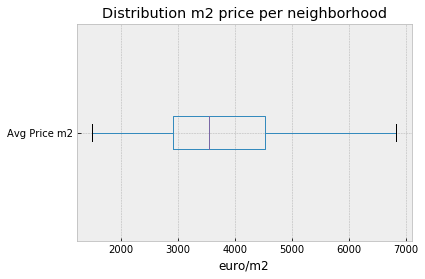

In [12]:
df_house_price['Avg Price m2'].plot(kind='box', vert= False)
plt.title('Distribution m2 price per neighborhood')
plt.xlabel('euro/m2')
plt.savefig('boxpricem2.png')
plt.show()

The price per square meter vary from 1500 euro up to almost 7000. It is logical to expect higher prices near the center of the city, but Barcelona is also a coastal city. Where is the most expensive? Let's check the 3 most expensive neighborhoods

In [13]:
df_price_top3= df_price_coord.sort_values(by='Avg Price m2', ascending= False)[:3]
df_price_top3.reset_index(drop= True, inplace= True)
df_price_top3

,Barrio,Barrio Id,Avg Price m2,Latitude,Longitude
0,Diagonal Mar i el Front Marítim del Poblenou,69,6836,41.405241,2.213072
1,Pedralbes,21,6306,41.391035,2.110158
2,la Dreta de l'Eixample,07,6128,41.393885,2.168199


Checking the neighborhoods price distribution using a choropleth map

In [14]:
locations = df_price_top3[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
locationname= ['Diagonal Mar', 'Pedralbes',  'la Dreta de l Eixample']


m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

    
    
# Add the color for the choropleth:
m.choropleth(
 geo_data=geojson,
 name='choropleth',
 data=df_price_coord,
 columns=['Barrio Id', 'Avg Price m2'],
 key_on='feature.properties.C_Barri',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='price m2(€)'
)
folium.LayerControl().add_to(m)


for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup= locationname[point]).add_to(m)

m

The 3 most expensive neighboords form a line that cuts Barceolona from side to side. While Diagonal mar is very close to the wonderful beaches, 
Pedralbes, on the opposite side of the city and far from the sea, is a neighbourhood characterised by exclusivity and extravagance and home to celebrities such as Shakira and the football player David Villa. In the center we find  L'Eixample, the most popular residential area where to buy Barcelona an apartment.

### Venues Analysis

In [15]:
print('In average, there are {:.0f} venues per neighbohood group'.format(df_venues.shape[0]/df_price_coord.shape[0]))

In average, there are 45 venues per neighbohood group


I will check now how the venues are distributed with a histogram

Text(0.5, 0, 'n venues per neighborhood')

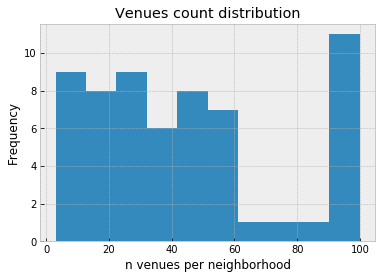

In [16]:
venues_neighborhood= df_venues[['Barrio', 'Venue']].groupby('Barrio').count()
venues_neighborhood.columns= ['Venues Count']
venues_neighborhood.plot(kind='hist', legend= None, figsize= (6,4))
plt.title('Venues count distribution')
plt.xlabel('n venues per neighborhood')

Note that 11 neighborhoods have 90 (or more) venues, and many has less than 50.  
I will now join the price sf and the venues once, in order to check if a relationship exists between price and number of venues

In [17]:
venues_neighborhood= venues_neighborhood.join(df_house_price.set_index('Barrio'))

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


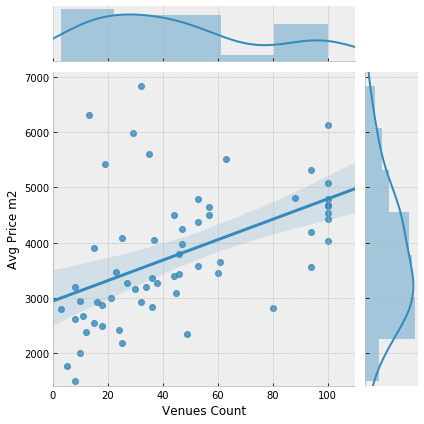

In [18]:
a= sns.jointplot(x='Venues Count', y='Avg Price m2', kind='reg', xlim=(0,110), ylim=(1400, 7100), data= venues_neighborhood)

Let's use scipy to check the strength of the linear relationship

In [19]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(venues_neighborhood['Venues Count'], venues_neighborhood['Avg Price m2'])

In [20]:
print(f'A modereate positive linear relationship(r: {r_value}, p: {p_value}) exists between the number of venues and the avg price per m2')

A modereate positive linear relationship(r: 0.4859737831373143, p: 7.175028763549475e-05) exists between the number of venues and the avg price per m2


In [21]:
df_venues= df_venues.merge(df_house_price, on= 'Barrio')

After checking how the venues are distributed, let's take a look at the most common venues in Barcelona.

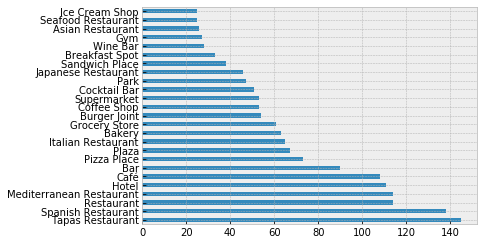

In [22]:
df_venues['Venue Category'].value_counts()[:25].plot(kind= 'barh' )

I will use pd to create a dummy dataframe for the venue category

In [23]:
# one hot encoding
barcelona_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
barcelona_onehot['Barrio'] = df_venues['Barrio'] 

# move neighborhood column to the first column
fixed_columns = [barcelona_onehot.columns[-1]] + list(barcelona_onehot.columns[:-1])
barcelona_onehot = barcelona_onehot[fixed_columns]

barcelona_onehot[:5]

,Barrio,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vacation Rental,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,el Raval,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,el Raval,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,el Raval,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,el Raval,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,el Raval,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
barcelona_grouped = barcelona_onehot.groupby('Barrio').mean().reset_index()
print(barcelona_grouped.shape) # checking the new shape
barcelona_grouped[:5]

(61, 277)


,Barrio,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vacation Rental,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Can Baró,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Ciutat Meridiana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Diagonal Mar i el Front Marítim del Poblenou,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Horta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Hostafrancs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.022727,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.0


I will now check the 10 most common venues per the 3 most expensive neighborhoods

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [88]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Barrio']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Barrio'] = barcelona_grouped['Barrio']

for ind in np.arange(barcelona_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barcelona_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted[neighborhoods_venues_sorted['Barrio'].isin(df_price_top3['Barrio'].tolist())]

,Barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Diagonal Mar i el Front Marítim del Poblenou,Mediterranean Restaurant,Restaurant,Hotel,Beach Bar,Beach,Italian Restaurant,Beer Garden,Thai Restaurant,Buffet,Track
6,Pedralbes,Mediterranean Restaurant,Garden,Hotel,Soccer Stadium,Café,Bus Stop,Garden Center,Nightclub,Pizza Place,Spanish Restaurant
43,la Dreta de l'Eixample,Hotel,Boutique,Restaurant,Hostel,Mediterranean Restaurant,Tapas Restaurant,Café,Seafood Restaurant,Cocktail Bar,Clothing Store


I will now add to the df that is going to be used for clustering the venues count, standardize with dividing the count per 100, the maximum number of venues in a neighborhood

In [89]:
barcelona_grouped_clustering= barcelona_grouped.merge(venues_neighborhood.reset_index()[['Barrio', 'Venues Count']], on='Barrio')

barcelona_grouped_clustering['Venues Count']= barcelona_grouped_clustering['Venues Count']/100

barcelona_grouped_clustering.drop('Barrio', 1, inplace= True)

To find the neighborhood groups I will use the K-means clustering algorithm.   
Let's use the elbow method to find the number of k

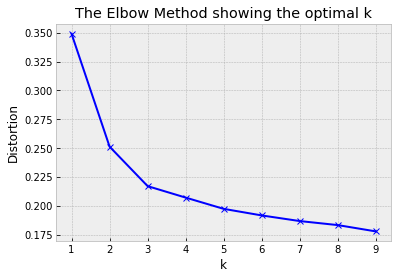

In [90]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(barcelona_grouped_clustering)
    kmeanModel.fit(barcelona_grouped_clustering)
    distortions.append(sum(np.min(cdist(barcelona_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / barcelona_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

K = 3. It's time to initialize and fit the k mean algorithm

In [91]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init= 50, max_iter=1e4, random_state=1234).fit(barcelona_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 0,
       0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 1, 1, 2, 1,
       2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 2, 0], dtype=int32)

### 4. Results

In [92]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


barcelona_merged = df_price_coord.merge(venues_neighborhood.reset_index()[['Barrio', 'Venues Count']], on= 'Barrio')

# merge barcelona_grouped with barcelona_data to add latitude/longitude for each neighborhood
barcelona_merged = barcelona_merged.join(neighborhoods_venues_sorted.set_index('Barrio'), on='Barrio')
barcelona_merged[:5]

,Barrio,Barrio Id,Avg Price m2,Latitude,Longitude,Venues Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,el Raval,01,4034,41.378963,2.170491,100,1,Spanish Restaurant,Tapas Restaurant,Cocktail Bar,Bar,Restaurant,Hotel,Mediterranean Restaurant,Indian Restaurant,Mexican Restaurant,Monument / Landmark
1,el Barri Gòtic,02,4660,41.381099,2.177446,100,1,Bar,Spanish Restaurant,Tapas Restaurant,Italian Restaurant,Cocktail Bar,Hotel,Plaza,Mediterranean Restaurant,Coffee Shop,Pizza Place
2,la Barceloneta,03,4815,41.377203,2.190159,88,1,Paella Restaurant,Mediterranean Restaurant,Bar,Tapas Restaurant,Spanish Restaurant,Beach,Ice Cream Shop,Seafood Restaurant,Pizza Place,Restaurant
3,Sant Pere,04,4689,41.386794,2.183437,100,1,Tapas Restaurant,Bar,Cocktail Bar,Wine Bar,Restaurant,Italian Restaurant,Hotel,Café,Burger Joint,Dessert Shop
4,el Fort Pienc,05,4500,41.397418,2.181487,44,0,Hotel,Restaurant,Chinese Restaurant,Mexican Restaurant,Theater,Mediterranean Restaurant,Hostel,Spanish Restaurant,Breakfast Spot,Beer Bar


In [93]:
barcelona_merged[:5].drop(columns= ['Barrio Id', 'Longitude', 'Latitude'])

,Barrio,Avg Price m2,Venues Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,el Raval,4034,100,1,Spanish Restaurant,Tapas Restaurant,Cocktail Bar,Bar,Restaurant,Hotel,Mediterranean Restaurant,Indian Restaurant,Mexican Restaurant,Monument / Landmark
1,el Barri Gòtic,4660,100,1,Bar,Spanish Restaurant,Tapas Restaurant,Italian Restaurant,Cocktail Bar,Hotel,Plaza,Mediterranean Restaurant,Coffee Shop,Pizza Place
2,la Barceloneta,4815,88,1,Paella Restaurant,Mediterranean Restaurant,Bar,Tapas Restaurant,Spanish Restaurant,Beach,Ice Cream Shop,Seafood Restaurant,Pizza Place,Restaurant
3,Sant Pere,4689,100,1,Tapas Restaurant,Bar,Cocktail Bar,Wine Bar,Restaurant,Italian Restaurant,Hotel,Café,Burger Joint,Dessert Shop
4,el Fort Pienc,4500,44,0,Hotel,Restaurant,Chinese Restaurant,Mexican Restaurant,Theater,Mediterranean Restaurant,Hostel,Spanish Restaurant,Breakfast Spot,Beer Bar


Now, I will examine each cluster and determine the discriminating venue categories that distinguish each cluster. At the end, based on the defining categories, I am going to assign a name to each cluster.

In [94]:
most_common_venues= {}
for n in range (3):
    most_common_venues[str(n)]= set(barcelona_merged.loc[barcelona_merged['Cluster Labels'] == n, barcelona_merged.columns[[1] + list(
        range(5, barcelona_merged.shape[1]))]]['1st Most Common Venue'].values)

In [95]:
most_common_venues

{'0': {'Bakery',
  'Clothing Store',
  'Grocery Store',
  'Hotel',
  'Italian Restaurant',
  'Japanese Restaurant',
  'Mediterranean Restaurant',
  'Pizza Place',
  'Restaurant',
  'Soccer Stadium',
  'Spanish Restaurant',
  'Tapas Restaurant'},
 '1': {'Bar',
  'Café',
  'Hotel',
  'Italian Restaurant',
  'Paella Restaurant',
  'Restaurant',
  'Spanish Restaurant',
  'Tapas Restaurant'},
 '2': {'Café',
  'Deli / Bodega',
  'Diner',
  'Garden',
  'Grocery Store',
  'Hotel',
  'Mediterranean Restaurant',
  'Metro Station',
  'Pizza Place',
  'Planetarium',
  'Plaza',
  'Soccer Field',
  'Spanish Restaurant',
  'Supermarket',
  'Tapas Restaurant'}}

Let's check how many venues there are in average for each cluster

In [96]:
barcelona_merged.groupby('Cluster Labels')['Venues Count'].mean()

Cluster Labels
0    46.652174
1    96.153846
2    17.000000
Name: Venues Count, dtype: float64

1. Cluster 0 (red) has, in average, 46 venues per neighborhood. The most common venues are bakeries,  Italian and Spanish restaurants (but other cuisines can be found too), hotels but we can find numerous clothing and grocery stores too.
2. Cluster 1 (azure) has really high average number of venues, these are mainly bars, cafés, hotels, traditional and tapas restaurants.
3. Cluster 2 (blue) has the lowest number of venues. In this cluster the venues are of many different categories, going going form hotels and restaurants  to gardens, diners, supermarkets and soccer fields.

Finally, let's visualize the resulting clusters on a map

In [97]:
# create map
map_clusters = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
random.shuffle(rainbow)

map_clusters.choropleth(
 geo_data=geojson,
 name='choropleth',
 data=df_house_price,
 columns=['Barrio Id', 'Avg Price m2'],
 key_on='feature.properties.C_Barri',
 fill_color='YlOrRd',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='price m2 (€)'
)
folium.LayerControl().add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barcelona_merged['Latitude'], barcelona_merged['Longitude'], barcelona_merged['Barrio'], barcelona_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

# Save to html
map_clusters.save('barcelona_venue_cluster.html')

map_clusters


## 5. Findings

In [98]:
barcelona_merged['Cluster Labels']= barcelona_merged['Cluster Labels'].map({0: 'Mixed', 1: 'Turistic', 2: 'Local'})

Thanks to the K-means clustering algorithm it has been possible to identify 3 different neighborhood groups. One is full of touristic places (cluster 1, labeled now as touristic), one has a number of different venues, more suited for an everyday lifestyle (cluster 0, local) the last one ( cluster 2, mixed) is a mix the two other clusters are closed to different store types.

At the end let's see how the price differs between the different clusters

Text(0.5, 1.0, 'Clusters Average Price per m2 ')

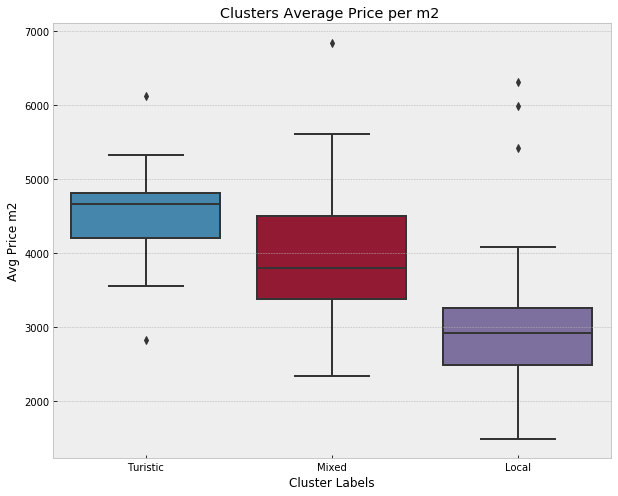

In [108]:
plt.figure(figsize= (10,8))
sns.boxplot( x= 'Cluster Labels', y= 'Avg Price m2', data=barcelona_merged)
plt.title('Clusters Average Price per m2 ')